In [39]:
import pandas as pd
import seaborn
import numpy as np

### Importing Data

In [40]:
df = pd.read_csv("data/ytdf3.csv")
df.head(5)

,Authorname,Comments
0,Radin Černý,Summary for those who are not fans of long vid...
1,Filipe Freire,More a linux starter tutorial than a docker on...
2,Troll Gamer,"Hello mosh, i am a 15 year old kid and was lea..."
3,Ash Moore,"Hi Mosh, I just want to say thank you so much ..."
4,Irfan Shaikh,Excellent beginners tutorial. You have not jum...


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Authorname  100 non-null    object
 1   Comments    100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


### Data preprocessing 

Checking duplicates

In [42]:
df.duplicated().sum()
df.shape

(100, 2)

In [43]:
df = df.drop_duplicates()
df.shape

(97, 2)

Remove emojis and special characters

In [44]:
import re
def cleaning_comments(comment):
  comment = re.sub("[🤣|🤭|🤣|😁|🤭|❤️|👍|🏴|😣|😠|💪|🙏|😞|🌺|🌸|🌞|🌻|💐|💓|😥|💔|😪|😑|🏽|😢|😑|😇|💜|🪴|🙌🏻|🇨🇦|🕊|🕯|😭|😔|💙|🏼|✝|🇿]+",'',comment)
  comment = re.sub("[0-9]+","",comment)
  comment = re.sub("[\:|\@|\)|\*|\.|\$|\!|\?|\,|\%|\"|\(|\-|\”|\#|\!|\/|\«|\»|\&|\n|\'|\;|\!|<|>|\'|\’|\\\\]+"," ",comment)
  return comment

df['Comments'] = df['Comments'].apply(cleaning_comments)

Convert to lower case

In [45]:
lower = lambda x: x.lower()
df['Comments'] = df['Comments'].apply(lower)

Get the polarity with the stopwords

In [46]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

#Create scores col
df['Scores'] = df['Comments'].apply(lambda x: sid.polarity_scores(x))

#Create compund score
df['Compound'] = df['Scores'].apply(lambda score_dict: score_dict['compound'])

#label based on score
df['Polarity'] = df['Compound'].apply(lambda c: 'neutral' if -0.05 < c < 0.05 else ('negative' if c < -0.05 else 'positive'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maann\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Get the polarity without the stopwords

In [47]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

stop = stopwords.words('english')

#Create comments without stopwords col
df['comments wo stopwords'] = df['Comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Add scores and polarity col without stopwords

In [48]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

df['Scores wo stopwords'] = df['comments wo stopwords'].apply(lambda x: sid.polarity_scores(x))

df['compound wo stopwords'] = df['Scores wo stopwords'].apply(lambda score_dict: score_dict['compound'])

df['polarity wo stopwords'] = df['compound wo stopwords'].apply(lambda c: 'neutral' if -0.05 < c < 0.05 else ('negative' if c < -0.05 else 'positive'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maann\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [55]:
df["Length"] = df["Comments"].str.len()
df.head(5)

,Authorname,Comments,Scores,Compound,Polarity,comments wo stopwords,Scores wo stopwords,compound wo stopwords,polarity wo stopwords,Length
0,Radin Černý,summary for those who are not fans of long vid...,"{'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'comp...",0.9612,positive,summary fans long videos name video says docke...,"{'neg': 0.0, 'neu': 0.797, 'pos': 0.203, 'comp...",0.9186,positive,670
1,Filipe Freire,more a linux starter tutorial than a docker on...,"{'neg': 0.0, 'neu': 0.742, 'pos': 0.258, 'comp...",0.7869,positive,linux starter tutorial docker one good enough ...,"{'neg': 0.0, 'neu': 0.667, 'pos': 0.333, 'comp...",0.6124,positive,129
2,Troll Gamer,hello mosh i am a year old kid and was learn...,"{'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compou...",0.9652,positive,hello mosh year old kid learning python videos...,"{'neg': 0.0, 'neu': 0.586, 'pos': 0.414, 'comp...",0.9652,positive,435
3,Ash Moore,hi mosh i just want to say thank you so much ...,"{'neg': 0.037, 'neu': 0.755, 'pos': 0.209, 'co...",0.9557,positive,hi mosh want say thank much providing valuable...,"{'neg': 0.06, 'neu': 0.543, 'pos': 0.397, 'com...",0.9774,positive,671
4,Irfan Shaikh,excellent beginners tutorial you have not jum...,"{'neg': 0.0, 'neu': 0.903, 'pos': 0.097, 'comp...",0.3291,positive,excellent beginners tutorial jumped complex th...,"{'neg': 0.0, 'neu': 0.764, 'pos': 0.236, 'comp...",0.5719,positive,140


Compare the polarity ratio with stopwords and without them

In [50]:
df['Polarity'].value_counts()

positive    90
neutral      4
negative     3
Name: Polarity, dtype: int64

In [51]:
df['polarity wo stopwords'].value_counts()

positive    90
neutral      4
negative     3
Name: polarity wo stopwords, dtype: int64

Checking the negative comments

In [58]:
neg = df[df["Polarity"] == "negative"]

neg.head()

,Authorname,Comments,Scores,Compound,Polarity,comments wo stopwords,Scores wo stopwords,compound wo stopwords,polarity wo stopwords,Length
48,Joshua Alabre,hey man nice course i m having trouble with ...,"{'neg': 0.097, 'neu': 0.842, 'pos': 0.061, 'co...",-0.4588,negative,hey man nice course trouble docker action sect...,"{'neg': 0.138, 'neu': 0.74, 'pos': 0.122, 'com...",-0.1531,negative,301
66,LOEHCRACK RECOMMEND ON INSTAGRAM,i cannot thank you enough my dad passed away ...,"{'neg': 0.116, 'neu': 0.816, 'pos': 0.067, 'co...",-0.1828,negative,cannot thank enough dad passed away unable acc...,"{'neg': 0.141, 'neu': 0.735, 'pos': 0.124, 'co...",0.1230,positive,276
75,29 Naman Kumar,the dislikes are given by the people who stru...,"{'neg': 0.101, 'neu': 0.899, 'pos': 0.0, 'comp...",-0.4019,negative,dislikes given people structure coding courses...,"{'neg': 0.184, 'neu': 0.816, 'pos': 0.0, 'comp...",-0.4019,negative,154


#### Investigating the relationship between comment length and polarity

In [53]:
a = df.groupby("Polarity")
a["Length"].mean()

Polarity
negative    243.666667
neutral     147.500000
positive    169.177778
Name: Length, dtype: float64

It seems that negative comments tends to be longer

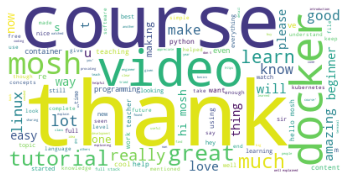

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

comments = df["Comments"].values
b = WordCloud(background_color="white").generate(str(comments))

plt.imshow(b)
plt.axis("off")
plt.show()